In [34]:
import math
from scipy.optimize import minimize, newton
import copy
import mpmath

from joblib import Parallel, delayed

import sympy
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, pi, I
from sympy.abc import x, y, z

from numba import jit
%matplotlib inline
sympy.init_session(use_latex=True)

IPython console for SymPy 1.3 (Python 3.6.4-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.3/



In [35]:
epsilon = symbols("epsilon")
mu = symbols("mu")
lambda_ = symbols("lambda") ## длинна волны света 0.55
k0 = (pi * 2) / lambda_ 

In [36]:
phi = Function("phi")
betta = symbols("beta", real=True)  # Проницаемость среды
betta_y = symbols("beta_y")
betta_z = symbols("beta_z")

betta_y_test = Derivative(phi(y), y) 
betta_z_test = Derivative(phi(z), y)  

In [37]:
E_z = Function('E_z') 
H_z = Function('H_z')

In [38]:
epsilon_s = symbols("epsilon_s") 
mu_s = symbols("mu_s")

Ce_s1 = symbols("C_se1") 
Ce_s2 = symbols("C_se2")  
Ch_s1 = symbols("C_sh1") 
Ch_s2 = symbols("C_sh2") 

eq_s_ez = Derivative(E_z(x), x, x) + (k0**2)*(epsilon_s*mu_s - betta**2)*E_z(x)
eq_s_hz = Derivative(H_z(x), x, x) + (k0**2)*(epsilon_s*mu_s - betta**2)*H_z(x)

eq_s_ez_sloved = dsolve(eq_s_ez)
eq_s_hz_sloved = dsolve(eq_s_hz)

eq_s_ez_sloved = eq_s_ez_sloved.subs([["C1", Ce_s1], ["C2", Ce_s2]])
eq_s_hz_sloved = eq_s_hz_sloved.subs([["C1", Ch_s1], ["C2", Ch_s2]])

In [39]:
epsilon_f = symbols("epsilon_f") # Электрическая проницаемость
mu_f = symbols("mu_f")  # Магнитная проницаемостьт

Ce_f1 = symbols("C_fe1") 
Ce_f2 = symbols("C_fe2")  
Ch_f1 = symbols("C_fh1") 
Ch_f2 = symbols("C_fh2")  

eq_f_ez = Derivative(E_z(x), x, x) + (k0**2)*(epsilon_f*mu_f - betta**2)*E_z(x)
eq_f_hz = Derivative(H_z(x), x, x) + (k0**2)*(epsilon_f*mu_f - betta**2)*H_z(x)

eq_f_ez_sloved = dsolve(eq_f_ez)
eq_f_hz_sloved = dsolve(eq_f_hz)

eq_f_ez_sloved = eq_f_ez_sloved.subs([["C1", Ce_f1], ["C2", Ce_f2]])
eq_f_hz_sloved = eq_f_hz_sloved.subs([["C1", Ch_f1], ["C2", Ch_f2]])

eq_f_hz_sloved = eq_f_hz_sloved.subs({
    betta:betta*I,
    epsilon_f:-epsilon_f,
    pi:pi*I
})

eq_f_ez_sloved = eq_f_ez_sloved.subs({
    betta:betta*I,
    epsilon_f:-epsilon_f,
    pi:pi*I
})

#eq_f_ez_sloved = Equality(eq_f_ez_sloved.lhs, ((Ce_f1 * (cos(-1 * 2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_) + I * sin(-1 * 2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_))) + (Ce_f2 * (cos(2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_) + I * sin(2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_)))))
#eq_f_hz_sloved = Equality(eq_f_hz_sloved.lhs, ((Ch_f1 * (cos(-1 * 2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_) + I * sin(-1 * 2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_))) + (Ch_f2 * (cos(2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_) + I * sin(2 * pi * x * sqrt(epsilon_f * mu_f - betta**2) / lambda_)))))

In [40]:
epsilon_c = symbols("epsilon_c") # Электрическая проницаемость
mu_c = symbols("mu_c")  # Магнитная проницаемостьт

Ce_c1 = symbols("C_ce1") 
Ce_c2 = symbols("C_ce2")  
Ch_c1 = symbols("C_ch1") 
Ch_c2 = symbols("C_ch2")  

eq_c_ez = Derivative(E_z(x), x, x) + (k0**2)*(epsilon_c*mu_c - betta**2)*E_z(x)
eq_c_hz = Derivative(H_z(x), x, x) + (k0**2)*(epsilon_c*mu_c - betta**2)*H_z(x)

eq_c_ez_sloved = dsolve(eq_c_ez)
eq_c_hz_sloved = dsolve(eq_c_hz)

eq_c_ez_sloved = eq_c_ez_sloved.subs([["C1", Ce_c1], ["C2", Ce_c2]])
eq_c_hz_sloved = eq_c_hz_sloved.subs([["C1", Ch_c1], ["C2", Ch_c2]])


In [41]:
#c
left_part = (1 / ((k0**2)*(epsilon_c*mu_c - betta_z**2)))
E_y_c = left_part*(I*k0*mu_c*Derivative(H_z(x), x)+(k0**2)*betta_y*betta_z*E_z(x))
H_y_c = left_part*(-(k0**2)*betta_y*betta_z*H_z(x)-I*k0*epsilon_c*Derivative(E_z(x), x))
#f
left_part = (1 / ((k0**2)*(epsilon_f*mu_f - betta_z**2)))
E_y_f = left_part*(I*k0*mu_f*Derivative(H_z(x), x)+(k0**2)*betta_y*betta_z*E_z(x))
H_y_f = left_part*(-(k0**2)*betta_y*betta_z*H_z(x)-I*k0*epsilon_f*Derivative(E_z(x), x))
#s
left_part = (1 / ((k0**2)*(epsilon_s*mu_s - betta_z**2)))
E_y_s = left_part*(I*k0*mu_s*Derivative(H_z(x), x)+(k0**2)*betta_y*betta_z*E_z(x))
H_y_s = left_part*(-(k0**2)*betta_y*betta_z*H_z(x)-I*k0*epsilon_s*Derivative(E_z(x), x))

In [42]:
eq_c_hz_diff = diff(eq_c_hz_sloved.rhs,x)
eq_s_hz_diff = diff(eq_s_hz_sloved.rhs,x)
eq_f_hz_diff = diff(eq_f_hz_sloved.rhs,x)
eq_c_ez_diff = diff(eq_c_ez_sloved.rhs,x)
eq_s_ez_diff = diff(eq_s_ez_sloved.rhs,x)
eq_f_ez_diff = diff(eq_f_ez_sloved.rhs,x)

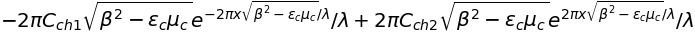

In [43]:
eq_c_hz_diff

In [44]:
H_y_c = H_y_c.subs({
    H_z(x) : eq_c_hz_sloved.rhs,
    Derivative(E_z(x), x) : eq_c_ez_diff,
})

H_y_f = H_y_f.subs({
    H_z(x) : eq_f_hz_sloved.rhs,
    Derivative(E_z(x), x) : eq_f_ez_diff,
})

H_y_s = H_y_s.subs({
    H_z(x) : eq_s_hz_sloved.rhs,
    Derivative(E_z(x), x) : eq_s_ez_diff,
})

In [45]:
E_y_c = E_y_c.subs({
    E_z(x) : eq_c_ez_sloved.rhs,
    Derivative(H_z(x), x) : eq_c_hz_diff,
})

E_y_f = E_y_f.subs({
    E_z(x) : eq_f_ez_sloved.rhs,
    Derivative(H_z(x), x) : eq_f_hz_diff,
})

E_y_s = E_y_s.subs({
    E_z(x) : eq_s_ez_sloved.rhs,
    Derivative(H_z(x), x) : eq_s_hz_diff,
})

In [46]:
fez_sloved = eq_f_ez_sloved
fhz_sloved = eq_f_ez_sloved

In [47]:
Ez_cf = Equality(eq_c_ez_sloved.rhs - eq_f_ez_sloved.rhs, 0)
Ez_fs = Equality(eq_f_ez_sloved.rhs - eq_s_ez_sloved.rhs, 0)

Hz_cf = Equality(eq_c_hz_sloved.rhs - eq_f_hz_sloved.rhs, 0)
Hz_fs = Equality(eq_f_hz_sloved.rhs - eq_s_hz_sloved.rhs, 0)

In [48]:
Ey_cf = Equality(E_y_c - E_y_f, 0)
Ey_fs = Equality(E_y_f - E_y_s, 0)

Hy_cf = Equality(H_y_c - H_y_f, 0)
Hy_fs = Equality(H_y_f - H_y_s, 0)

In [49]:
Ez_fs = Ez_fs.subs({'x': 0, 'beta': betta_z, 'C_ce2': 0, 'C_ch2': 0, 'C_se1': 0, 'C_sh1': 0})
Hz_fs = Hz_fs.subs({'x': 0, 'beta': betta_z, 'C_ce2': 0, 'C_ch2': 0, 'C_se1': 0, 'C_sh1': 0})
Ey_fs = Ey_fs.subs({'x': 0, 'beta_y': 0, 'beta': betta_z, 'C_ce2': 0, 'C_ch2': 0, 'C_se1': 0, 'C_sh1': 0})
Hy_fs = Hy_fs.subs({'x': 0, 'beta_y': 0, 'beta': betta_z, 'C_ce2': 0, 'C_ch2': 0, 'C_se1': 0, 'C_sh1': 0})

In [50]:
d = symbols("d")

In [51]:
Ey_fs_ = Equality(Ey_fs.lhs * (epsilon_s*mu_s - betta_z**2) * (((2*pi)*(epsilon_f*mu_f - betta_z**2))), 0).simplify()
Hy_fs_ = Equality(Hy_fs.lhs * (epsilon_s*mu_s - betta_z**2) * (((2*pi)*(epsilon_f*mu_f - betta_z**2))), 0).simplify()
Ey_cf_ = Equality(Ey_cf.lhs * (epsilon_c*mu_c - betta_z**2) * (((2*pi)*(2*pi)*(epsilon_f*mu_f - betta_z**2))), 0).simplify()
Hy_cf_ = Equality(Hy_cf.lhs * (epsilon_c*mu_c - betta_z**2) * (((2*pi)*(2*pi)*(epsilon_f*mu_f - betta_z**2))), 0).simplify()

In [52]:
Ey_fs_new = Equality(Ey_fs_.lhs * 1/(2*pi), 0)
Hy_fs_new = Equality(Hy_fs_.lhs * 1/(2*pi), 0)

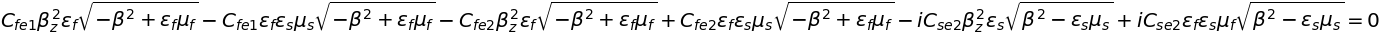

In [53]:
Hy_fs_new.expand()

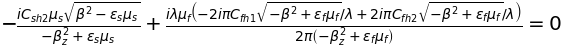

In [54]:
Ey_fs

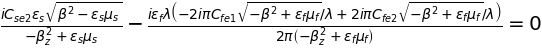

In [55]:
Hy_fs

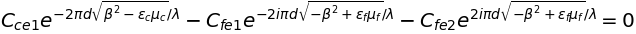

In [56]:
Ez_cf_kek = Ez_cf.subs({
    betta_y : 0,
    Ce_c2 : 0,
    x : d
})
Ez_cf_kek
Hz_cf_kek = Hz_cf.subs({
    betta_y : 0,
    Ch_c2 : 0,
    x : d
})
Ez_cf_kek

In [57]:
Hy_cf_kek = Hy_cf_.subs({
    betta_y : 0,
    Ce_c2 : 0,
    betta_z : betta,
    x : d
})
Hy_cf_kek_expand = Hy_cf_kek.expand()
Ey_cf_kek = Ey_cf_.subs({
    betta_y : 0,
    Ch_c2 : 0,
    betta_z : betta,
    x : d
})
Ey_cf_kek_expand = Ey_cf_kek.expand()

In [58]:
L1_kek = sympy.linear_eq_to_matrix([Ez_fs, Hy_fs_new.expand(), Ez_cf_kek, Hy_cf_kek_expand], Ce_c1, Ce_f1, Ce_f2, Ce_s2)[0]
L2_kek = sympy.linear_eq_to_matrix([Hz_fs, Ey_fs_new.expand(), Hz_cf_kek, Ey_cf_kek_expand], Ch_c1, Ch_f1, Ch_f2, Ch_s2)[0]

In [59]:
L2_kek

⎡                                                             0               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                             0               
⎢                                                                             
⎢                                                            ______________   
⎢                                                           ╱  2              
⎢                                                  -2⋅π⋅d⋅╲╱  β  - ε_c⋅μ_c    
⎢                                                  ─────────────────────────  
⎢                                                              λ              
⎢                                                 ℯ                           
⎢                                                   

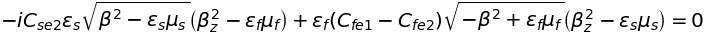

In [60]:
Hy_fs_new

In [61]:
L1_kek = L1_kek.subs({
    mu_c : 1,
    mu_f : 1,
    mu_s : 1,
    lambda_ : 0.55,
    #h: 2*lambda_,
    betta_z: betta,
    epsilon_c : 1,
    epsilon_f : 1.565 ** 2,
    epsilon_s : 1.47 ** 2
})

L2_kek = L2_kek.subs({
    mu_c : 1,
    mu_f : 1,
    mu_s : 1,
    lambda_ : 0.55,
    #h: 2*lambda_,
    betta_z: betta,
    epsilon_c : 1,
    epsilon_f : 1.565 ** 2,
    epsilon_s : 1.47 ** 2
})

omg = L1_kek.det()
omg2 = L2_kek.det()

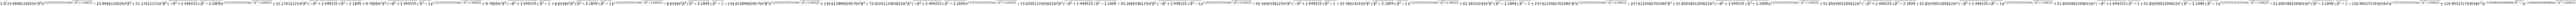

In [62]:
omg

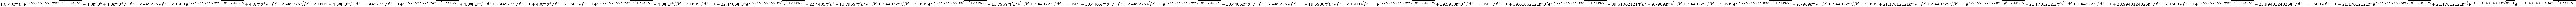

In [63]:
omg2

In [64]:
class DBettaAdapter:
    def __init__(self, left, right, determinant, d_):
        self.init_right_bound = right
        self.init_left_bound = left
        self.raw_deterninant = determinant
        self.set_d(d_)
        self.factor = 1
        self.epsilon = 1e-6
        self.min = []
    
    def set_d(self, d_):
        self.determinant = self.raw_deterninant.subs({"d":d_})
        self.d = d_

    def set_bounds(self, left, right):
        self.right_bound = right
        self.left_bound = left
    
    def func(self, b):
        b = b[0]
        eval_ = self.determinant.evalf(subs={betta:b})
        if b < self.left_bound or b > self.right_bound:
            return 1000
        else:
            ans = mpmath.power(Abs(eval_), 2)
        return ans * self.factor

    def opt(self):
        mid = (self.right_bound - self.left_bound)/2 + self.left_bound
        res = minimize(self.func, [mid], method ="Nelder-Mead")
        return res
    
    def draw_plot(self, num_points=100):
        #for i in arr:
        #    res_.append(self.func([i]))
        arr, step, res_ = self.eval_array(num_points)
        
        plt.plot(arr, np.array(res_, dtype=np.float64))
        plt.xlabel("betta")
        plt.ylabel('determinant')
        plt.show()
    
    def eval_array(self, num_points=100):
        res_ = []
        arr = np.linspace(self.left_bound, self.right_bound, num_points)
        step = arr[1] - arr[0]
        for i in arr:
            res_.append(self.func([i]))
        return arr, step, np.array(res_)
    
    @staticmethod
    def find_local_min(arr):
        diff = np.diff(arr)
        res = []
        for i in range(len(diff)-1):
            #print(diff[i], diff[i+1], i)
            if diff[i]<0 and diff[i+1]>0:
                res.append(i)
        return res
    
    def get_mins(self, num_points=100):
        arr, step, res_ = self.eval_array(num_points)
        init_mins = self.find_local_min(res_)
        
        local_mins = []
        start = copy.deepcopy(self.left_bound)
        for min_ in init_mins:
            left_bound = start + min_ * step
            right_bound = start + (min_ + 3) * step
            #print(left_bound, right_bound)
            self.set_bounds(left_bound, right_bound)
            opt_result = self.opt()
            local_mins.append([opt_result.x, opt_result.fun])
        return local_mins
    
    def find_min_d_range(self, d_array, num_points=100):
        result = []
        for d in d_array:
            self.set_d(d)
            self.set_bounds(self.init_left_bound, self.init_right_bound)
            mins_ = [i[0] for i in self.get_mins(num_points)]
            result.append([d, mins_])
        return result
    
    def find_min_d_range_parallel(self, d_array, num_points=100):
        result = Parallel(n_jobs=8)(delayed(self.parallel_adapter)(i, num_points) for i in d_array)
        return result
    
    def parallel_adapter(self, d, num_points=100):
            self.set_d(d)
            self.set_bounds(self.init_left_bound, self.init_right_bound)
            mins_ = self.get_mins(num_points)
            #mins_ = [i[0] for i in self.get_mins(num_points)]
            return d, mins_

In [65]:
k = DBettaAdapter(1.4695, 1.56505, omg, 1)

In [66]:
d_arr = np.linspace(0.1, 2, 10)

In [ ]:
%%time
k = DBettaAdapter(1.4695, 1.56505, omg, 1)
d_arr = np.linspace(0.01, 3, 150)
res = k.find_min_d_range_parallel(d_arr, 150)

In [ ]:
%%time
k2 = DBettaAdapter(1.4695, 1.56505, omg2, 1)
d_arr = np.linspace(0.01, 3, 150)
res2 = k2.find_min_d_range_parallel(d_arr, 150)

In [ ]:
bettas = [[] for _ in range(len(res2[-1][-1]))]
d_s = [i[0] for i in res2]
for d, betta_s in res2:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])

In [ ]:
def pad(arr, d_s):
    target = len(d_s) - len(arr)
    return d_s[target:], np.pad(np.array(arr), [target, 0], "edge")[target:]

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
for i in range(len(bettas)):
    d_s, pad_ = pad(bettas[i], d_s)
    plt.plot(d_s, pad_, "o")

plt.xlabel("d")
plt.ylabel('Betta')
plt.savefig(f"plots/temp.png")

In [ ]:
bettas = [[] for _ in range(len(res[-1][-1]))]
d_s = [i[0] for i in res]
for d, betta_s in res:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])
        
for i in range(len(bettas)):
    d_s, pad_ = pad(bettas[i], d_s)
    plt.plot(d_s, pad_, "o")

plt.xlabel("d")
plt.ylabel('Betta')
plt.savefig(f"plots/temp.png")

In [75]:
L1_kek

⎡                                                           0                 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                           0                 
⎢                                                                             
⎢                                                                    ________ 
⎢                                                                   ╱  2      
⎢                                           -3.63636363636364⋅π⋅d⋅╲╱  β  - 1  
⎢                                          ℯ                                  
⎢                                                                             
⎢                                                  ________                   
⎢               ________                          ╱ 

In [ ]:
L2_kek

In [ ]:
bettas = [[] for _ in range(len(res[-1][-1]))]
d_s = [i[0] for i in res]
for d, betta_s in res:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])
        
for i in range(len(bettas)):
    d_s, pad_ = pad(bettas[i], d_s)
    plt.plot(d_s, pad_, "o")

bettas = [[] for _ in range(len(res2[-1][-1]))]
d_s = [i[0] for i in res2]
for d, betta_s in res2:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])
        
for i in range(len(bettas)):
    d_s, pad_ = pad(bettas[i], d_s)
    plt.plot(d_s, pad_, "o")

plt.xlabel("d")
plt.ylabel('Betta')
plt.savefig(f"plots/temp.png")

In [ ]:
def split_increasing_array(arr):
    res = []
    new_res = []
    for i in range(len(arr)-1):
        if arr[i]>arr[i+1]:
            new_res.append(arr[i])
            res.append(new_res)
            new_res = []
        else:
            new_res.append(arr[i])
    new_res.append(arr[i+1])
    res.append(new_res)
    return res

In [ ]:
target

In [ ]:
res

In [67]:
import pickle
with open('res.pickle', 'rb') as f:
    res = pickle.load(f)
with open('res2.pickle', 'rb') as f:
    res2 = pickle.load( f)

In [68]:
res

[(0.01, [[array([1.47000002]), 0.00020705580501060948]]),
 (0.030067114093959735, [[array([1.47000002]), 0.00011632862854038833]]),
 (0.05013422818791947, [[array([1.47000002]), 6.308248403328697e-05]]),
 (0.0702013422818792, [[array([1.47000026]), 0.0005247715191403642]]),
 (0.09026845637583893, [[array([1.47000026]), 0.0002610979259476644]]),
 (0.11033557046979865, [[array([1.47000026]), 0.00012265997538636462]]),
 (0.1304026845637584, [[array([1.47000026]), 5.346581569310624e-05]]),
 (0.15046979865771815, [[array([1.47000419]), 0.00034318797535966625]]),
 (0.17053691275167787, [[array([1.47000419]), 0.00011502238869079451]]),
 (0.1906040268456376, [[array([1.47003111]), 0.0002371092434237842]]),
 (0.21067114093959732, [[array([1.46995931]), 2.563800092442357e-05]]),
 (0.23073825503355708, [[array([1.47017471]), 1.633810375722514e-07]]),
 (0.2508053691275168,
  [[array([1.47132351]), 2.787192847300148e-05],
   [array([1.47173869]), 1.1839481458547952e-07]]),
 (0.27087248322147656,
  

In [69]:
target = list(map(split_increasing_array, bettas))
for i in range(len(target)):
    m = []
    for j in range(len(target[i])):
        try:
            m.extend(target[i][j])
        except: pass
    #[m.extend(i) for i in k]
    plt.plot(m)

NameError: name 'split_increasing_array' is not defined

In [ ]:
plt.ylim(1.471, 1.565)
bettas = [[] for _ in range(len(res[-1][-1]))]
d_s = [i[0] for i in res]
for d, betta_s in res:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])

target = list(map(split_increasing_array, bettas))
for i in range(6):
    m = []
    for j in target:
        try:
            m.extend(j[i])
        except: pass
    d_s = [i[0] for i in res]
    d_s, pad_ = pad(m, d_s)
    plt.plot(d_s, pad_)
    
bettas = [[] for _ in range(len(res2[-1][-1]))]
d_s = [i[0] for i in res2]
for d, betta_s in res2:
    for betta_i in range(len(betta_s)):
        bettas[betta_i].append(betta_s[betta_i][0])

target = list(map(split_increasing_array, bettas))
for i in range(6):
    m = []
    for j in target:
        try:
            m.extend(j[i])
        except: pass
    d_s = [i[0] for i in res2]
    d_s, pad_ = pad(m, d_s)
    plt.plot(d_s, pad_)
    #plt.plot()
plt.xlabel("d")
plt.ylabel('Betta')
plt.savefig(f"plots/temp.png")

In [ ]:
import random

In [ ]:
random.randint(0, 10000)

In [ ]:
L1_kek

In [70]:
static_d = res[50][0]

In [73]:
static_betta = res[50][1][1][0][0]
static_d

In [76]:
L1_slae = L1_kek.subs({
    betta : static_betta,
    d : static_d
})
L1_slae

⎡                     0                                           1           
⎢                                                                             
⎢                     0                                    0.09580167641804   
⎢                                                                             
⎢            -4.11678464003532⋅π                          -1.6524790984022⋅ⅈ⋅π
⎢           ℯ                                           -ℯ                    
⎢                                                                             
⎢                     2  -4.11678464003532⋅π                     2  -1.6524790
⎣0.898674504995764⋅ⅈ⋅π ⋅ℯ                     -5.48344230613534⋅π ⋅ℯ          

                               1                              -1         ⎤
                                                                         ⎥
                       -0.09580167641804              0.128341470244738⋅ⅈ⎥
                                                               

In [77]:
import numpy

def sas(A, eps=1e-15):
    u, s, vh = numpy.linalg.svd(A)
    null_space = numpy.compress(s <= eps, vh, axis=0)
    return null_space.T



a = numpy.array(L1_slae)
b = numpy.array([0, 0, 0, 0])
sas(a, b)

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_f

In [239]:
L1_list = L1_slae.tolist()

In [142]:
#Начало метода Гаусса
for k in range(0,3):
    for i in range(k, 4):
        for j in range(k, 4):
            if(L1_list[i][k] != 0):
                L1_list[i][j] /= L1_list[i][k]
    for i in range(k+1, 4):
        if(L1_list[i][k] != 0):
            for j in range(k, 4):
                L1_list[i][j] -= L1_list[k][j]

In [143]:
L1_list

In [148]:
C1 = symbols("C_1")
C2 = symbols("C_2")
C3 = symbols("C_3")
C4 = symbols("C_4")

In [156]:
a = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]

In [162]:
for i in range(0,4):
    for j in range(0,4):
        a[i][j] = L1_list[i][j]
        if((i == 3 or i == 2) and j ==3):
            a[i][j] = C4

In [209]:
b = [[0,0,0],[0,0,0],[0,0,0]]

In [210]:
for i in range(0, 3):
    for j in range(0, 3):
        b[i][j] = a[i][j]

In [211]:
y = [0, 0, -C4]

In [214]:
for i in range(0, 3):
    for j in range(i, 3):
        b[i][j] /= b[i][2]

In [215]:
for i in range(0, 2):
    for j in range(i, 3):
        b[i][j] -= b[2][j]
    y[i] -= y[2]

In [219]:
for i in range(0, 2):
    temp = b[i][1]
    for j in range(0,2):
        b[i][j] /= temp
    y[i] /= temp

In [222]:
b[0][1] -= b[1][1]
y[0] -= y[1]

In [225]:
y[0] /= b[0][0]
b[0][0] = 1

In [228]:
y

In [229]:
C_1 = y[0]
C_2 = y[1]
C_3 = y[2]
C_4 = C4

In [238]:
#Метод гаусса
def meinGauss(OurList):
    Moda = OurList
    for k in range(0,3):
        for i in range(k, 4):
            for j in range(k, 4):
                if(Moda[i][k] != 0):
                    Moda[i][j] /= Moda[i][k]
        for i in range(k+1, 4):
            if(Moda[i][k] != 0):
                for j in range(k, 4):
                    Moda[i][j] -= Moda[k][j]

    C1 = symbols("C_1")
    C2 = symbols("C_2")
    C3 = symbols("C_3")
    C4 = symbols("C_4")
    a = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    for i in range(0,4):
        for j in range(0,4):
            a[i][j] = Moda[i][j]
            if((i == 3 or i == 2) and j ==3):
                a[i][j] = C4
    b = [[0,0,0],[0,0,0],[0,0,0]]
    for i in range(0, 3):
        for j in range(0, 3):
            b[i][j] = a[i][j]
    y = [0, 0, -C4]
    for i in range(0, 3):
        for j in range(i, 3):
            b[i][j] /= b[i][2]
    for i in range(0, 2):
        for j in range(i, 3):
            b[i][j] -= b[2][j]
        y[i] -= y[2]
    for i in range(0, 2):
        temp = b[i][1]
        for j in range(0,2):
            b[i][j] /= temp
        y[i] /= temp
    b[0][1] -= b[1][1]
    y[0] -= y[1]
    y[0] /= b[0][0]
    b[0][0] = 1
    C_1 = y[0]
    C_2 = y[1]
    C_3 = y[2]
    C_4 = C4
    return [C_1, C_2, C_3, C_4]
